In [1]:
import numpy as np
import argparse
import json
from os.path import join
import tensorflow as tf
import glob
from PIL import Image , ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import tensorflow.contrib.eager as tfe
import sys
import scipy.io as scio
import cv2
print(tf.VERSION) 
print(sys.version)
#os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7"

1.12.0
3.6.6 (default, Jun 28 2018, 04:42:43) 
[GCC 5.4.0 20160609]


In [2]:
#dataset
X_dir = '/data/fjsdata/ASOCT/dataset_16_LRS_final/train_data'
Y_dir = '/data/fjsdata/ASOCT/dataset_16_LRS_final/train_label'
X_train = list()
Y_train = list()
X_val = list()
Y_val = list()

def valueTransform(image):
    a1 = 65535 / 256 * 150
    a2 = 65535 / 256 * 87
    image = np.where(image > a2, 255 * (image - a2) / (a1 - a2), 0)
    image[image > 255] = 255
    image = image.astype(np.uint8)
    return image
    
for X_name in os.listdir(X_dir): 
    #handle feature
    X_image = scio.loadmat(os.path.join( X_dir, X_name))['mm']
    X_image = valueTransform(X_image)
    X_image = cv2.resize(X_image, (128,128), interpolation=cv2.INTER_AREA) #width×heigth×channel
    #handle label
    Y_name = os.path.splitext(X_name)[0]+'.png'
    #Y_image = Image.open(os.path.join( Y_dir, Y_name)).convert('L')
    Y_image = Image.open(os.path.join( Y_dir, Y_name)).split()[0]#split band
    Y_image = np.array(Y_image.resize((128,128),Image.ANTIALIAS))
    if X_name[0:4] == 'test':#val
        X_val.append(X_image.reshape(128,128,1))
        Y_val.append(Y_image.reshape(128,128,1))
    else:#train
        X_train.append(X_image.reshape(128,128,1))
        Y_train.append(Y_image.reshape(128,128,1))

X_train = (np.array(X_train)/255).astype(np.float32)
Y_train = np.array(Y_train)
X_val = (np.array(X_val)/255).astype(np.float32)
Y_val = np.array(Y_val)
print ('The size of feature in Train set is : {}'.format(X_train.shape))
print ('The size of label in Train set is : {}'.format(Y_train.shape))
print ('The size of feature in Val set is: {}'.format(X_val.shape))
print ('The size of label in Val set is : {}'.format(Y_val.shape))

The size of feature in Train set is : (17385, 128, 128, 1)
The size of label in Train set is : (17385, 128, 128, 1)
The size of feature in Val set is: (128, 128, 128, 1)
The size of label in Val set is : (128, 128, 128, 1)


In [3]:
#check dataset, 
def value_count(arr):
    arr = np.array(arr)
    key = np.unique(arr)
    result = {}
    for k in key:
        mask = (arr == k)
        arr_new = arr[mask]
        v = arr_new.size
        result[k] = v
    return result
print (value_count(Y_train[0]))
print (value_count(Y_val[0]))
print(Y_train.shape)
print (Y_val.shape)

{0: 6413, 1: 484, 2: 5653, 3: 3834}
{0: 8170, 1: 458, 2: 3907, 3: 3849}
(17385, 128, 128, 1)
(128, 128, 128, 1)


In [4]:
class unet_seg:
    def __init__(self, lr=0.001):
        #global parameters
        self.lr = lr
        #set network structure
        self.add_placeholders()
        self.add_weight()
        self.add_model()
        self.add_loss()
        self.add_optimizer()
        self.init_sess()
        
    def add_placeholders(self):    
        self.X_input = tf.placeholder(tf.float32)
        self.Y_input = tf.placeholder(tf.float32)
    
    def add_weight(self):
        initializer = tf.initializers.glorot_uniform()
        def get_weight( shape , name ):
            return tf.Variable( initializer( shape ) , name=name , trainable=True )

        shapes = [ [ 3 , 3 , 1 , 16 ] ,   [ 3 , 3 , 16 , 16 ] , 
                   [ 3 , 3 , 16 , 32 ] ,  [ 3 , 3 , 32 , 32 ] ,
                   [ 3 , 3 , 32 , 64 ] ,  [ 3 , 3 , 64 , 64 ] ,
                   [ 3 , 3 , 64 , 128 ] , [ 3 , 3 , 128 , 128 ] ,
                   [ 3 , 3 , 128 , 256 ] ,[ 3 , 3 , 256 , 256 ] ,
                   [ 3 , 3 , 128 , 384 ], [ 3 , 3 , 128 , 128 ],
                   [ 3 , 3 , 64 , 192 ],  [ 3 , 3 , 64 , 64 ],
                   [ 3 , 3 , 32 , 96 ],   [ 3 , 3 , 32 , 32 ],
                   [ 3 , 3 , 16 , 48 ],   [ 3 , 3 , 16 , 16 ],
                   [ 1 , 1 , 16 , 1 ] 
                 ]
        weights = []
        for i in range( len( shapes ) ):
            weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )
        self.weights = weights
        
    def add_model(self):
        def conv2d_down( inputs , filters , stride_size ):
            #print( 'conv2d down' )
            out = tf.nn.conv2d( inputs , filters , strides=stride_size , padding='SAME' ) 
            return tf.nn.leaky_relu( out , alpha=0.2 ) 

        def maxpool_down( inputs , pool_size , stride_size ):
            #print( 'maxpool down' )
            return tf.nn.max_pool( inputs , ksize=pool_size , padding='VALID' , strides=stride_size )

        def conv2d_up( inputs , filters , stride_size , output_shape ):
            #print( 'conv2d up' )
            out = tf.nn.conv2d_transpose( inputs , filters , output_shape=output_shape , strides=stride_size , padding='SAME' ) 
            return tf.nn.leaky_relu( out , alpha=0.2 ) 

        def maxpool_up( inputs , size ):
            #print( 'maxpool up' )
            in_dimen = tf.shape( inputs )[ 1 ]
            out_dimen = tf.cast( tf.round( in_dimen * size ) , dtype=tf.int32 ) 
            return tf.image.resize_images( inputs , [ out_dimen , out_dimen ] , method=1 )#nearest
        #forward
        x = tf.cast(self.X_input , dtype=tf.float32 )
        batch_size = tf.shape( x )[0]
        c1 = conv2d_down( x , self.weights[ 0 ] , stride_size=[1,1,1,1] ) 
        c1 = conv2d_down( c1 , self.weights[ 1 ] , stride_size=[1,1,1,1] ) 
        p1 = maxpool_down( c1 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c2 = conv2d_down( p1 , self.weights[ 2 ] , stride_size=[1,1,1,1] )
        c2 = conv2d_down( c2 , self.weights[ 3 ] , stride_size=[1,1,1,1] ) 
        p2 = maxpool_down( c2 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c3 = conv2d_down( p2 , self.weights[ 4 ] , stride_size=[1,1,1,1] ) 
        c3 = conv2d_down( c3 , self.weights[ 5 ] , stride_size=[1,1,1,1] ) 
        p3 = maxpool_down( c3 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c4 = conv2d_down( p3 , self.weights[ 6 ] , stride_size=[1,1,1,1] )
        c4 = conv2d_down( c4 , self.weights[ 7 ] , stride_size=[1,1,1,1] )
        p4 = maxpool_down( c4 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c5 = conv2d_down( p4 , self.weights[ 8 ] , stride_size=[1,1,1,1] )
        c5 = conv2d_down( c5 , self.weights[ 9 ] , stride_size=[1,1,1,1] )   

        p5 = maxpool_up( c5 , 2 )
        concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
        c6 = conv2d_up( concat_1 , self.weights[ 10 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 16 , 16 , 128 ] )
        c6 = conv2d_up( c6 , self.weights[ 11 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 16 , 16 , 128 ] )  

        p6 = maxpool_up( c6 , 2 )
        concat_2 = tf.concat( [ p6 , c3 ] , axis=-1 ) 
        c7 = conv2d_up( concat_2 , self.weights[ 12 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 32 , 32 , 64 ] )
        c7 = conv2d_up( c7 , self.weights[ 13 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 32 , 32 , 64 ] )  

        p7 = maxpool_up( c7 , 2 )
        concat_3 = tf.concat( [ p7 , c2 ] , axis=-1 ) 
        c8 = conv2d_up( concat_3 , self.weights[ 14 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 64 , 64 , 32 ] )
        c8 = conv2d_up( c8 , self.weights[ 15 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 64 , 64 , 32 ] )   

        p8 = maxpool_up( c8 , 2 )
        concat_4 = tf.concat( [ p8 , c1 ] , axis=-1 ) 
        c9 = conv2d_up( concat_4 , self.weights[ 16 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 128 , 128 , 16 ] )
        c9 = conv2d_up( c9 , self.weights[ 17 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 128 , 128 , 16 ] )  

        output = tf.nn.conv2d( c9 , self.weights[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] , padding='SAME' ) 
        self.Y_output = output
    
    def add_loss(self):
        #self.loss = tf.losses.sigmoid_cross_entropy( self.Y_input , self.Y_output ) 
         self.loss = tf.losses.mean_squared_error( self.Y_input , self.Y_output ) 
            
    def add_optimizer(self):
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.loss)
        
    def init_sess(self):
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        self.config.allow_soft_placement = True
        self.sess = tf.Session(config=self.config)
        self.sess.run(tf.global_variables_initializer())
#define model
tf_model = unet_seg()

In [5]:
#train model
#verbose = 10
batchSize=100
num_batches = X_train.shape[0] // batchSize + 1 
pre_loss = 0.0
while True:#convergence
    losses = []
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([X_train.shape[0], (i+1)*batchSize])
        X_batch = X_train[min_idx: max_idx]
        Y_batch = Y_train[min_idx: max_idx]
        _, tmp_loss = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                         feed_dict={tf_model.X_input: X_batch,tf_model.Y_input: Y_batch})
        losses.append(tmp_loss)
        #if verbose and i % verbose == 0:
        #    sys.stdout.write('\r{} / {} : loss = {}'.format(i, num_batches, np.mean(losses[-verbose:])))
        #    sys.stdout.flush()
    sys.stdout.write("\nMean loss in this epoch is: {}".format( np.mean(losses) ))
    sys.stdout.flush()
    #whether convergence
    if abs( np.mean(losses) - pre_loss)<0.001:
        break
    else:
        pre_loss = np.mean(losses)


Mean loss in this epoch is: 1.9657946825027466
Mean loss in this epoch is: 0.9111306071281433
Mean loss in this epoch is: 0.7683554291725159
Mean loss in this epoch is: 0.5985637307167053
Mean loss in this epoch is: 0.5162415504455566
Mean loss in this epoch is: 0.5695023536682129
Mean loss in this epoch is: 0.4940950572490692
Mean loss in this epoch is: 0.4914245307445526
Mean loss in this epoch is: 0.39611026644706726
Mean loss in this epoch is: 0.3862736225128174
Mean loss in this epoch is: 0.3683902323246002
Mean loss in this epoch is: 0.35525622963905334
Mean loss in this epoch is: 0.3487369418144226
Mean loss in this epoch is: 0.3398837447166443
Mean loss in this epoch is: 0.30900582671165466
Mean loss in this epoch is: 0.28820866346359253
Mean loss in this epoch is: 0.2776663303375244
Mean loss in this epoch is: 0.2694588601589203
Mean loss in this epoch is: 0.2690540552139282

In [19]:
#performance of adversarial val
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_val,tf_model.Y_input: Y_val}) #prediction
mIoUs = []
intersection = []
union = []
for i in range(len(Y_val)):
    a = Y_pred[i]
    #a_one_hot = tf.one_hot(tf.nn.top_k(a).indices, tf.shape(a)[2])#turn softmax to onehot 
    #a = tf_model.sess.run(a_one_hot).astype(int)
    b = Y_val[i]
    #a = np.where(a.flatten()==0,0,1)
    #b = np.where(b.flatten()==0,0,1)
    #intersection=np.logical_and(a,b)
    #union=np.logical_or(a,b)
    #intersection = np.where(abs(a.flatten()-b.flatten())<0.1,1,0)
    #union = np.where(b.flatten()==0,0,1)
    #iou_score = np.sum(intersection) / np.sum(union)
    iou_score = np.where(abs(a.flatten()-b.flatten())<0.5,1,0)
    mIoUs.append(np.mean(iou_score))
    sys.stdout.write('\r{} / {} : IoU = {}'.format(i, len(Y_val), np.mean(iou_score)))
    sys.stdout.flush()
print('===> mIoU: ' + str(round(np.nanmean(mIoUs) * 100, 2)))

127 / 128 : IoU = 0.95953369140625===> mIoU: 87.21


(1024, 2048, 3)


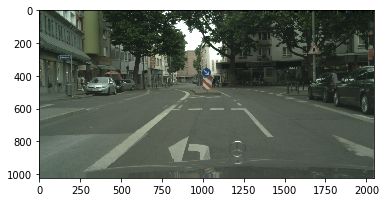

In [13]:
import cv2
import numpy
from matplotlib import pyplot as plt
import scipy.io as scio

#print(mat.keys())#dict_keys(['__header__', '__version__', '__globals__', 'mm'])
#mat = scio.loadmat('/data/fjsdata/ASOCT/dataset_16_LRS_final/train_data/test_20180403_145833_R_CASIA2_LRS_032.mat')
#img = mat['mm']
#h,w,c = img.shape
#plt.imshow(img.reshape([h,w])) # 显示图片
#plt.show()

#img = cv2.imread('/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/c0100_20181102_111708_R_CASIA2_LGC_002.jpg')
img = cv2.imread('/data/comcode/models/research/deeplab/datasets/cityscapes/leftImg8bit/test/mainz/mainz_000003_017171_leftImg8bit.png')
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)